In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from tqdm import tqdm


In [2]:
genome_info_url= "https://ezmeta.unige.ch/CMMG/Supplementary_Tables_and_Figures/Tables/Table_S3_genome_info.tsv"
genome_info= pd.read_table(genome_info_url,index_col=0)

quality_formula="completeness - 5*contamination"

genome_info['QualityScore']= genome_info.eval(quality_formula)

In [3]:
# assert that all genomes are associated with a sample, except the one from iMGMC that come from co-assembly

assert not genome_info.query('Study_set!="iMGMC"').Sample.isnull().any()
# assert that all genomes are associated with a species
assert not genome_info.Species.isnull().any()

# Rarefaction

In [4]:


# function to calculate rarefaction
def Rarifaction(mapping_table,key_sample,key_species,N_iterations=50,N_steps=100):
    """
        key is the name for samples
    """
    
    assert key_sample in mapping_table.columns
    assert key_species in mapping_table.columns

    
    unique_samples= mapping_table[key_sample].unique()
    N_samples= unique_samples.shape[0]
    
    # predefine matrix for rarifaction numbers
    # n samples. x replicate
    N= pd.DataFrame(index= np.linspace(1,N_samples, min(N_steps,N_samples)  ,dtype=int),
                   columns= range(N_iterations))




    # Itterate
    for i in tqdm(N.columns):
        
        # start with all samples and itteratively select a subset e.g go from right to left
        samples_set= unique_samples.copy()

        for n in reversed(N.index):

            samples_set= np.random.choice(samples_set,n,replace=False)

            # Select genomes that are from samples that are in the sample_set
            Csample= mapping_table.loc[mapping_table[key_sample].isin(samples_set)]
            
            # calculate the number of species we have in the subset
            
        
            
            N.loc[n,i] =Csample[key_species].unique().shape[0]
            
    return N



def plot_rarifaction_curve(N,ci='sd',**kws):
    sns.lineplot(x='variable',y='value',data=N.T.melt().astype(float),ci=ci,**kws)

In [5]:
# calcualte rarefaction for all genomes that are not co-assembled
Nall= Rarifaction(genome_info.query('Study_set!="iMGMC"'),key_sample='Sample',key_species='Species')

100%|██████████| 50/50 [00:30<00:00,  1.66it/s]


In [6]:
# Rarefaction for genomes from MAGs for this study

Nmag2 = Rarifaction(genome_info.query('Study_set=="mMAG2"'),key_sample='Sample',key_species='Species')

100%|██████████| 50/50 [00:18<00:00,  2.72it/s]


In [7]:
# Rarefaction for genomes from single-sample assembled genomes from Lesker et al.
Nmag1 = Rarifaction(genome_info.query('Study_set=="mMAG"'),key_sample='Sample',key_species='Species')

100%|██████████| 50/50 [00:15<00:00,  3.18it/s]


In [8]:
Nref = Rarifaction(genome_info.query('Study_set=="RefSeq"'),key_sample='Sample',key_species='Species')

100%|██████████| 50/50 [00:04<00:00, 11.46it/s]


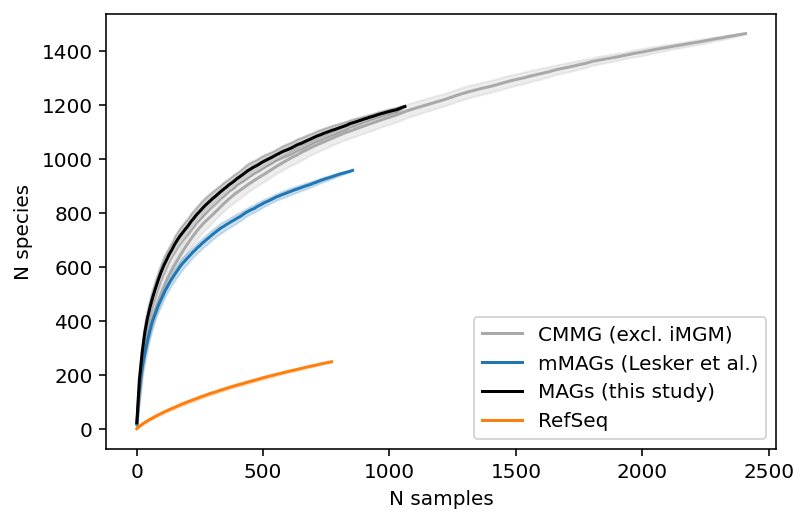

In [9]:
plot_rarifaction_curve(Nall,label='CMMG (excl. iMGM)',color='darkgrey')
plot_rarifaction_curve(Nmag1,label='mMAGs (Lesker et al.)')
plot_rarifaction_curve(Nmag2,label='MAGs (this study)',color='k')
plot_rarifaction_curve(Nref,label='RefSeq')


plt.ylabel('N species')
plt.xlabel('N samples')
plt.legend(loc='lower right',)



##  Rarefaction of MAGs with and without singletons
iMGM genomes are excluded as they are co-assembled
Refseq genomes are excluded as they often create new species with only one sample

In [10]:
genome_info_mag= genome_info.query('Study_set!="iMGMC" & Study_set!="RefSeq"  ')
assert not genome_info_mag.Isolate.any()


# rerefaction for all MAGs
Nall_mag= Rarifaction(genome_info_mag,key_sample='Sample',key_species='Species')

100%|██████████| 50/50 [00:30<00:00,  1.62it/s]


In [11]:
# remove genomes that are part of singleton species
Nsamples_per_species= genome_info.groupby(['Species','BioSample']).size().groupby(level=0).sum()
non_singleton_species= list(Nsamples_per_species.index[Nsamples_per_species>1])
genome_info__mag_ns= genome_info_mag.loc[genome_info_mag.Species.isin(non_singleton_species)]


In [12]:
# rarefaction without singletons
Nall_ns= Rarifaction(genome_info__mag_ns,key_sample='Sample',key_species='Species')

100%|██████████| 50/50 [00:29<00:00,  1.70it/s]


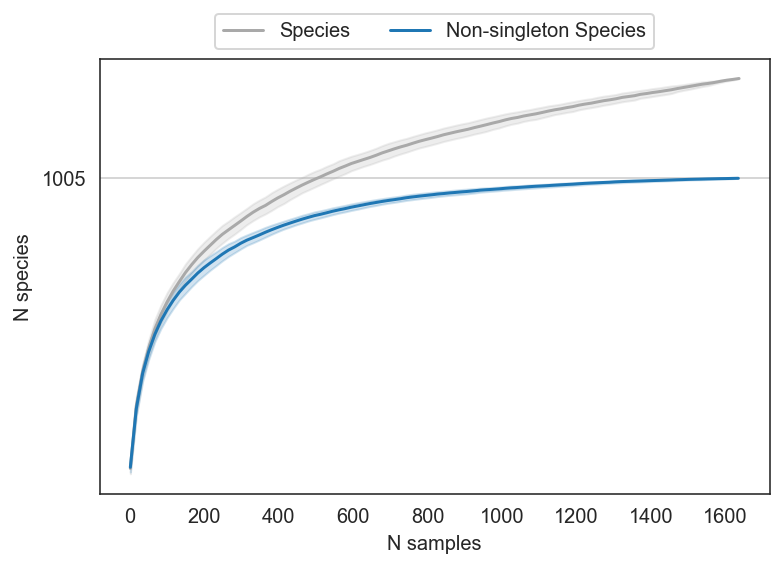

In [13]:
sns.set_style('white')

plot_rarifaction_curve(Nall_mag,label='Species',color='darkgrey')
plot_rarifaction_curve(Nall_ns,label='Non-singleton Species')


ax =plt.gca()

plt.grid(True,axis='y')
ax.set_yticks([Nall_ns.iloc[-1].median()])

plt.ylabel('N species')
plt.xlabel('N samples')
plt.legend(loc='lower center', ncol=2, bbox_to_anchor=(0.5,1))
